In [1]:
import tushare as ts
import pandas as pd 

df = ts.get_tick_data('600030',date='2019-07-08',src='tt')
df['time']=df.time.apply(lambda x:x[:5])

ddf=pd.DataFrame(columns=['time','price'])
ix=0
for name, group in df.groupby('time'):
    ddf.loc[ix]=[name, group.price.mean()]
    ix+=1
ddf.set_index('time', inplace=True)
ddf.tail()

/anaconda/lib/python3.6/site-packages/tushare/stock/trading.py:182: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  skiprows=[0])


,price
time,
14:54,23.1805
14:55,23.1740
14:56,23.1755
14:57,23.2000
15:00,23.1700


In [2]:
#exponentially smoothed moving average 
def EMV(N, price): 
    alpha=2/(1+N)
    emv=[price[0]]
    for i in price[1:]:
        emv.append(alpha*i+(1-alpha)*emv[-1])
    return emv

ddf['mv12']=EMV(12, list(ddf.price.values))
ddf['mv26']=EMV(26, list(ddf.price.values))
ddf['dif']=ddf['mv12']-ddf['mv26']
ddf['dem']=EMV(9, list(ddf.dif.values))
ddf['osc']=ddf['dif']-ddf['dem']
ddf['ben']=0

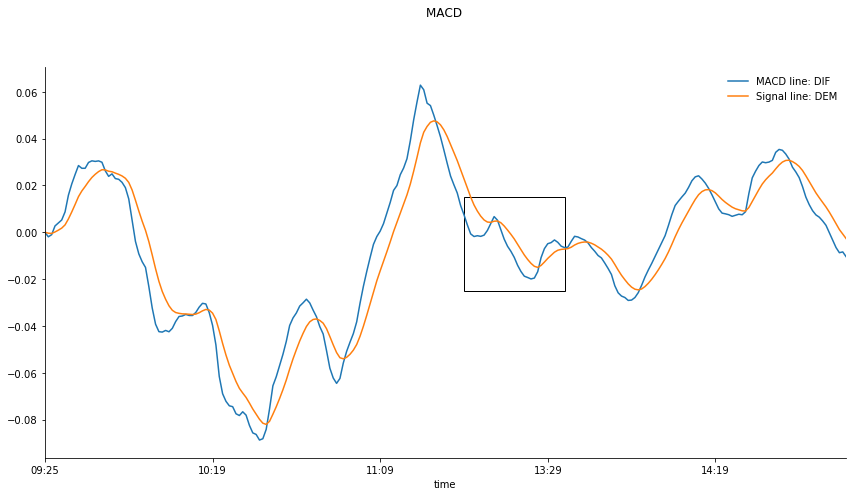

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib.patches as patches
 
fig, ax=plt.subplots(figsize=(12,7))
ddf['dif'].plot(label='MACD line: DIF')  
ddf['dem'].plot(label='Signal line: DEM') 

 
rect = patches.Rectangle((125,-0.025),30,0.04,linewidth=1,edgecolor='k',facecolor='none') 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
plt.title('MACD \n\n\n')
ax.add_patch(rect)
 
plt.legend(frameon=False);
plt.tight_layout()
plt.savefig('MACD')

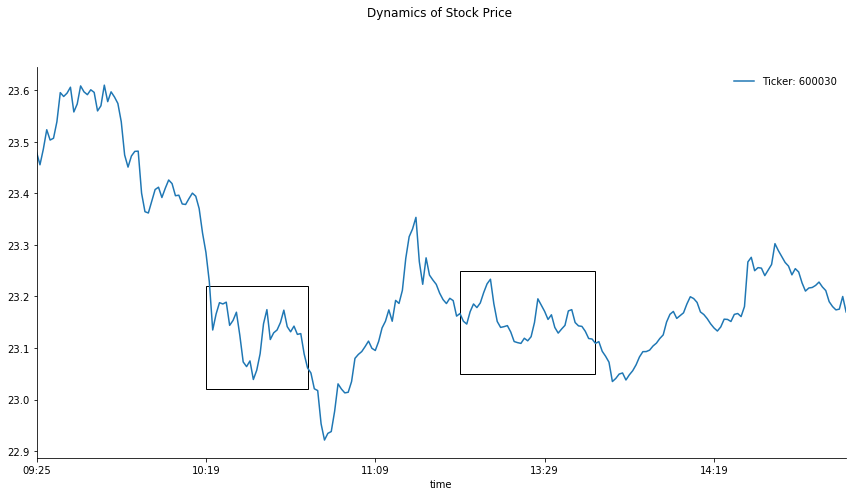

In [4]:
fig, ax=plt.subplots(figsize=(12,7))
ddf['price'].plot(label='Ticker: 600030') 

rect1 = patches.Rectangle((125,23.05),40,0.2,linewidth=1,edgecolor='k',facecolor='none') 
rect2 = patches.Rectangle((50,23.02),30,0.2,linewidth=1,edgecolor='k',facecolor='none') 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.title('Dynamics of Stock Price \n\n\n')
plt.legend(frameon=False);
plt.tight_layout()
plt.savefig('price')
 

In [5]:
def Policy(osc, price): 
    inv=[0]
    cash=[0]
    ini=osc[0]
    for item, px in zip(osc[1:], price[1:]): 
        if (ini>0.0001) &(item<-0.0001):
            inv.append(inv[-1]-100)
            cash.append(cash[-1]+100*px) #sell 
        elif (ini<-0.0001) & (item>0.0001):
            inv.append(inv[-1]+100)
            cash.append(cash[-1]-100*px) #buy
        else: 
            inv.append(inv[-1])
            cash.append(cash[-1])
        ini=item
        
    return inv, cash
ddf['inv'], ddf['cash'] =Policy(list(ddf.osc.values), list(ddf.price.values))
ddf['wealth']=ddf['inv']*ddf['price']+ddf['cash']
ddf['wealth']=ddf['wealth']-ddf['wealth'][0]
ddf.loc['15:00', 'inv']=0

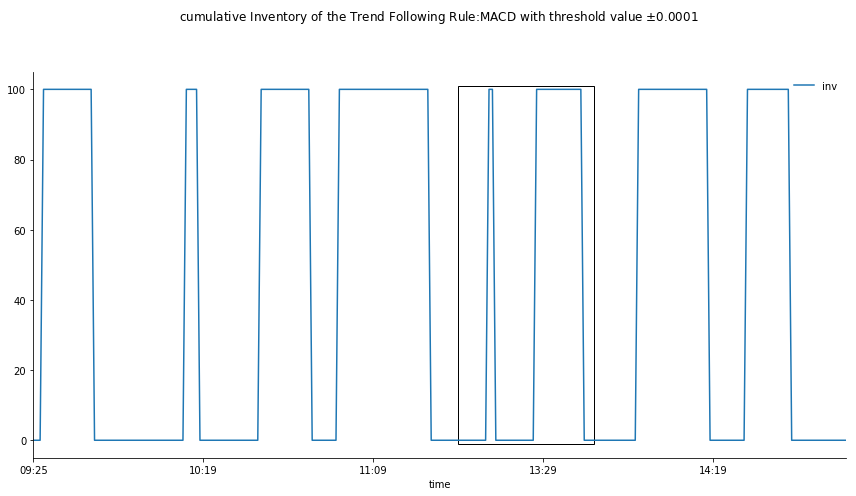

In [6]:
fig, ax=plt.subplots(figsize=(12,7))
ddf['inv'].plot()  

rect = patches.Rectangle((125,-1),40,102,linewidth=1,edgecolor='k',facecolor='none') 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.add_patch(rect)
plt.title('cumulative Inventory of the Trend Following Rule:MACD with threshold value $\pm 0.0001$ \n\n\n')
plt.legend(frameon=False);
plt.tight_layout()
plt.savefig('inv')
 

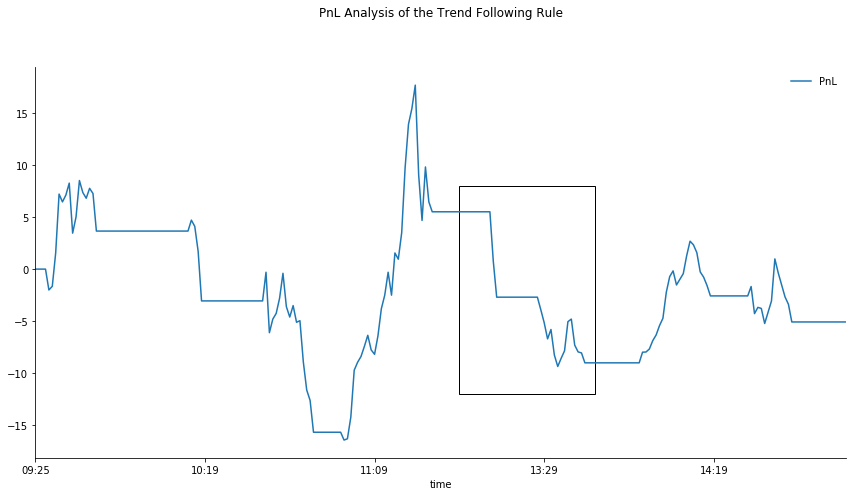

In [7]:
fig, ax=plt.subplots(figsize=(12,7))
ddf['wealth'].plot(label='PnL')  

rect1 = patches.Rectangle((125,-12),40,20,linewidth=1,edgecolor='k',facecolor='none') 
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
ax.add_patch(rect1)
plt.title('PnL Analysis of the Trend Following Rule\n\n\n')
plt.legend(frameon=False);
plt.tight_layout()
plt.savefig('pnl')
 

_One of the main problems with MACD is that it can often signal a possible
reversal but then no actual reversal actually happens - it produces a false positive.
The other problem is that MACD doesn't forecast all reversals. In other words, it
predicts too many reversals that don't occur and not enough real price reversals.
False positive often occurs when the price of an asset moves sideways, such as
the period of time marked in black rectangle._

####  To address the problem in Example 1, we decide to use Kalman-HMM filtering to filter the noise observations and, if possible, improve the trading signal quality.
---